<a href="https://colab.research.google.com/github/kumarmanishjha/6135_3/blob/master/HW3_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import math
import scipy

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable, grad
from torch.utils.data import dataset

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## GAN

In [0]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])

def get_data_loader(dataset_location, batch_size):
    trainvalid = datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

In [0]:
train, valid, test = get_data_loader("svhn", 64)

Using downloaded and verified file: svhn/train_32x32.mat
Using downloaded and verified file: svhn/test_32x32.mat


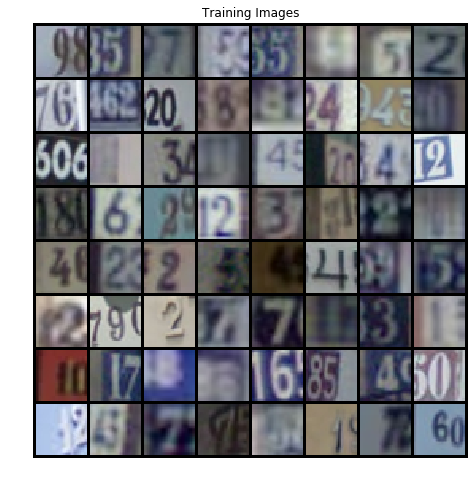

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
real_batch = next(iter(train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
cuda = True if torch.cuda.is_available() else False
img_size = 32
latent_dim = 100
channels = 3

In [0]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100, 256)
        self.deconv = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ELU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), -1, 1, 1)
        img = self.deconv(out)
        return img

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [0]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
lr, b1, b2 = 1e-4, 0.5, 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [102]:
#!mkdir images
if not os.path.exists('images'):
    os.mkdir('images')
!rm -f images/*

n_epochs = 20
n_critic = 5
lambda_gp = 10.

# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)
        
        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(gen_imgs.detach())
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, gen_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        """
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        """
        
        d_loss.backward()
        optimizer_D.step()
        
        # Train the generator every n_critic steps
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()
            
            # Generate a batch of images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

        batches_done = epoch * len(train) + i + 1
        if batches_done % 400 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %0.3f] [G loss: %0.3f]"
                % (epoch+1, n_epochs, i+1, len(train), d_loss.item(), g_loss.item())
            )
            save_image(gen_imgs.data[:64], "images/%d.png" % batches_done, nrow=8, normalize=True)

[Epoch 1/20] [Batch 400/1031] [D loss: 0.686] [G loss: 0.735]
[Epoch 1/20] [Batch 800/1031] [D loss: 0.621] [G loss: 0.726]
[Epoch 2/20] [Batch 169/1031] [D loss: 0.691] [G loss: 0.695]
[Epoch 2/20] [Batch 569/1031] [D loss: 0.657] [G loss: 0.785]
[Epoch 2/20] [Batch 969/1031] [D loss: 0.596] [G loss: 0.907]
[Epoch 3/20] [Batch 338/1031] [D loss: 0.708] [G loss: 0.691]
[Epoch 3/20] [Batch 738/1031] [D loss: 0.703] [G loss: 0.696]
[Epoch 4/20] [Batch 107/1031] [D loss: 0.691] [G loss: 0.616]
[Epoch 4/20] [Batch 507/1031] [D loss: 0.684] [G loss: 0.717]
[Epoch 4/20] [Batch 907/1031] [D loss: 0.715] [G loss: 0.751]
[Epoch 5/20] [Batch 276/1031] [D loss: 0.690] [G loss: 0.633]
[Epoch 5/20] [Batch 676/1031] [D loss: 0.681] [G loss: 0.715]
[Epoch 6/20] [Batch 45/1031] [D loss: 0.685] [G loss: 0.728]
[Epoch 6/20] [Batch 445/1031] [D loss: 0.691] [G loss: 0.688]
[Epoch 6/20] [Batch 845/1031] [D loss: 0.716] [G loss: 0.699]
[Epoch 7/20] [Batch 214/1031] [D loss: 0.726] [G loss: 0.727]
[Epoch 7/

## VAE

In [5]:
train, valid, test = get_data_loader("svhn", 64)

Using downloaded and verified file: svhn/train_32x32.mat
Using downloaded and verified file: svhn/test_32x32.mat


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
  
    def __init__(self, image_channels=1, h_dim=256, z_dim=100):
        super(VAE, self).__init__()
        
        # Q(z|X) -- encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 3),
            nn.ELU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ELU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(64, 256, 6),
            nn.ELU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        # P(X|z) -- decoder
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ELU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.ConvTranspose2d(128, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
        
    def reparameterize(self, mu, logvar):
      
        """std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size())
        z = mu + std * esp"""
        eps = torch.randn(mu.size()).cuda()
        z = eps.mul(logvar.mul(0.5).exp_()).add_(mu)

        return z

    
    def bottleneck(self, h):
        #print(self.fc1)
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def forward(self, x):
        h = self.encoder(x)
        #print("h:", h.size())
        z, mu, logvar = self.bottleneck(h)
        z_decoder = self.fc3(z)
        #print("z_decoder:", z_decoder.size())
        decoder = self.decoder(z_decoder)

        return decoder, mu, logvar

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(image_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def elbo_loss(output, target, mu, logvar):
    recon = torch.nn.functional.mse_loss(output, target, reduction='sum').to(device)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar)).to(device)
    elbo = recon + kld
    return elbo, recon, kld

In [9]:
epochs = 20
for epoch in range(1, epochs+1):
    for idx, (images, _) in enumerate(train):
        batch_size = images.size(0)
        images = images.to(device)
        #print("image size:", images.size())
        recon_images, mu, logvar = model(images)
        loss, bce, kld = elbo_loss(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    to_print = "Epoch[{}/{}] ELBO: {:.3f}, BCE: {:.3f}, KLD: {:.3f}"\
                .format(epoch, epochs, loss/batch_size, bce/batch_size, kld/batch_size)
    print("Training Data : ", to_print)

Training Data :  Epoch[1/20] ELBO: 102.913, BCE: 81.022, KLD: 21.891
Training Data :  Epoch[2/20] ELBO: 103.064, BCE: 76.191, KLD: 26.873
Training Data :  Epoch[3/20] ELBO: 138.469, BCE: 109.386, KLD: 29.083
Training Data :  Epoch[4/20] ELBO: 144.720, BCE: 112.942, KLD: 31.778
Training Data :  Epoch[5/20] ELBO: 80.988, BCE: 54.284, KLD: 26.704
Training Data :  Epoch[6/20] ELBO: 124.361, BCE: 90.163, KLD: 34.197
Training Data :  Epoch[7/20] ELBO: 84.003, BCE: 60.554, KLD: 23.449
Training Data :  Epoch[8/20] ELBO: 106.968, BCE: 73.786, KLD: 33.182
Training Data :  Epoch[9/20] ELBO: 82.910, BCE: 56.286, KLD: 26.624
Training Data :  Epoch[10/20] ELBO: 84.084, BCE: 53.268, KLD: 30.817
Training Data :  Epoch[11/20] ELBO: 92.187, BCE: 61.820, KLD: 30.367
Training Data :  Epoch[12/20] ELBO: 91.596, BCE: 60.831, KLD: 30.765
Training Data :  Epoch[13/20] ELBO: 68.861, BCE: 39.943, KLD: 28.917
Training Data :  Epoch[14/20] ELBO: 91.069, BCE: 59.270, KLD: 31.799
Training Data :  Epoch[15/20] ELBO:

## Qualitative Evaluation

### Generate Samples

In [0]:
# generate 1000 samples for both GAN & VAE models
n_samples = 1000
z = torch.randn(n_samples, 100, device=device)

samples_dir = "./gan/samples"
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)
generated = generator(z)
for i in range(n_samples):
    vutils.save_image(generated[i].view(3, 32, 32), samples_dir + '/%d.png' % (i+1), normalize=True)

samples_dir = "./vae/samples"
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)
generated = model.decoder(model.fc3(z))
for i in range(n_samples):
    vutils.save_image(generated[i].view(3, 32, 32), samples_dir + '/%d.png' % (i+1), normalize=True)

### Compare and Contrast Visual Samples

In [0]:
z = torch.randn(64, 100, device=device)
generated_gan = generator(z)
generated_vae = model.decoder(model.fc3(z))
vutils.save_image(generated_gan, 'images/gan-generated.png', normalize=True)
vutils.save_image(generated_vae, 'images/vae-generated.png', normalize=True)

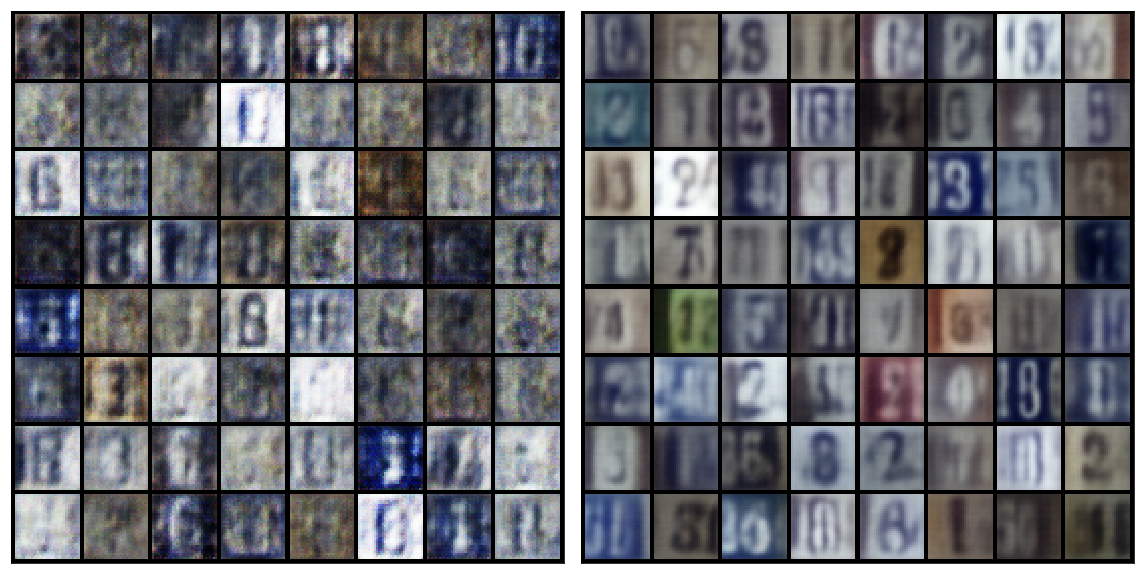

In [115]:
img1 = mpimg.imread('images/gan-generated.png')
img2 = mpimg.imread('images/vae-generated.png')
plt.figure(figsize=(16,16))
plt.subplot(1, 2, 1)
imgplot = plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
imgplot = plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

### Distantangled Representation

In [209]:
# GAN
z = torch.randn(1, 100, device=device)
# pick 10 random dimensions
n = 10
dims = sorted(np.random.choice(range(100), n, replace=False))
print(dims)
imgs = Tensor((n+1), 3, 32, 32).fill_(0.0)
x = generator(z).view(3, 32, 32)
imgs[0] = x
for i in range(0, n):
    epsilon = Tensor(1, 100).fill_(0.0)
    epsilon[0, dims[i]] = 5e-2
    imgs[i+1] = generator(z + epsilon).view(3, 32, 32)

[4, 9, 15, 19, 26, 27, 35, 50, 58, 73]


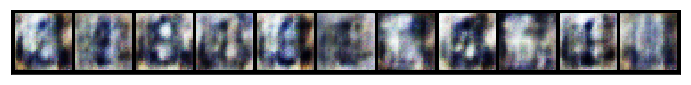

In [210]:
vutils.save_image(imgs, 'gan_distangaled.png', nrow=11, normalize=True)
imgs = mpimg.imread('gan_distangaled.png')
plt.figure(figsize=(12,4))
imgplot = plt.imshow(imgs)
plt.xticks([])
plt.yticks([])
plt.show()

In [199]:
# VAE
z = torch.randn(1, 100, device=device)
# pick 10 random dimensions
n = 10
dims = sorted(np.random.choice(range(100), n, replace=False))
print(dims)
imgs = Tensor((n+1), 3, 32, 32).fill_(0.0)
x = model.decoder(model.fc3(z)).view(3, 32, 32)
imgs[0] = x
for i in range(0, n):
    epsilon = Tensor(1, 100).fill_(0.0)
    epsilon[0, dims[i]] = 5e-2
    imgs[i+1] = model.decoder(model.fc3(z + epsilon)).view(3, 32, 32)

[11, 22, 66, 67, 74, 78, 82, 88, 94, 97]


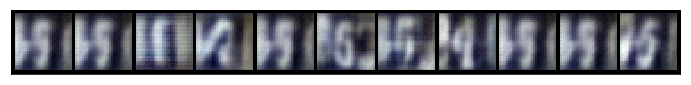

In [200]:
vutils.save_image(imgs, 'vae_distangaled.png', nrow=11, normalize=True)
imgs = mpimg.imread('vae_distangaled.png')
plt.figure(figsize=(12,4))
imgplot = plt.imshow(imgs)
plt.xticks([])
plt.yticks([])
plt.show()

### Interpolation

#### Latent Space

In [0]:
def gan_latent_interpolation(generator, z_1, z_2, alpha=0.1):
    n = int(1 / alpha)
    imgs = Tensor((n+1), 3, 32, 32).fill_(0.0)
    #imgs.requires_grad_(False)
    for i in range(0, n+1):
        z = (1 - i * alpha) * z_1 + i * alpha * z_2
        imgs[i] = generator(z).view(3, 32, 32)
    return imgs

def vae_latent_interpolation(model, z_1, z_2, alpha=0.1):
    n = int(1 / alpha)
    imgs = Tensor((n+1), 3, 32, 32).fill_(0.0)
    #imgs.requires_grad_(False)
    for i in range(0, n+1):
        z = (1 - i * alpha) * z_1 + i * alpha * z_2
        imgs[i] = model.decoder(model.fc3(z)).view(3, 32, 32)
    return imgs

In [0]:
z1 = torch.randn(1, 100, device=device)
z2 = torch.randn(1, 100, device=device)
img1 = gan_latent_interpolation(generator, z1, z2)
img2 = vae_latent_interpolation(model, z1, z2)

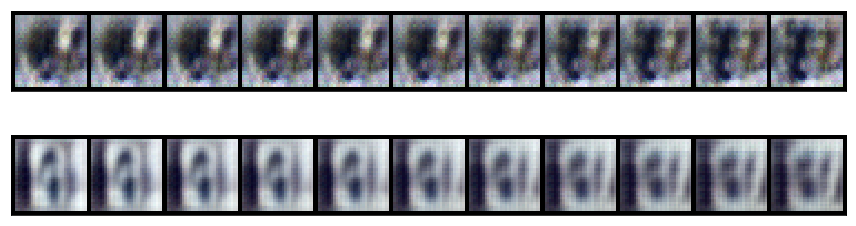

In [141]:
vutils.save_image(img1, 'gan_latent_interpolation.png', nrow=11,normalize=True)
img1 = mpimg.imread('gan_latent_interpolation.png')
vutils.save_image(img2, 'vae_latent_interpolation.png', nrow=11,normalize=True)
img2 = mpimg.imread('vae_latent_interpolation.png')
plt.figure(figsize=(12,4))
plt.subplot(2, 1, 1)
imgplot = plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
imgplot = plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

#### Data Space

In [0]:
def gan_data_interpolation(generator, z_1, z_2, alpha=0.1):
    n = int(1 / alpha)
    x_1 = generator(z_1).view(3, 32, 32)
    x_2 = generator(z_2).view(3, 32, 32)
    imgs = Tensor((n+1), 3, 32, 32).fill_(0.0)
    for i in range(0, n+1):
        imgs[i] = (1 - i * alpha) * x_1 + i * alpha * x_2
    return imgs

def vae_data_interpolation(model, z_1, z_2, alpha=0.1):
    n = int(1 / alpha)
    x_1 = model.decoder(model.fc3(z_1)).view(3, 32, 32)
    x_2 = model.decoder(model.fc3(z_2)).view(3, 32, 32)
    imgs = Tensor((n+1), 3, 32, 32).fill_(0.0)
    for i in range(0, n+1):
        imgs[i] = (1 - i * alpha) * x_1 + i * alpha * x_2
    return imgs

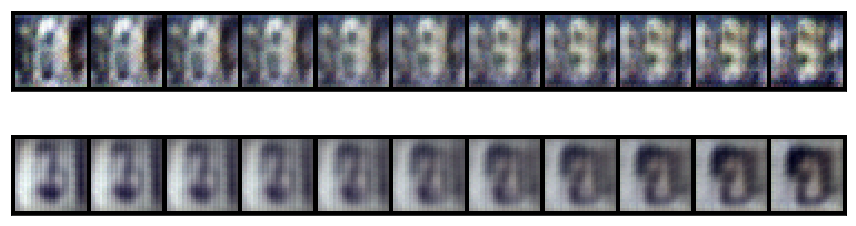

In [143]:
z1 = torch.randn(1, 100, device=device)
z2 = torch.randn(1, 100, device=device)
img1 = gan_data_interpolation(generator, z1, z2)
img2 = vae_data_interpolation(model, z1, z2)

vutils.save_image(img1, 'gan_data_interpolation.png', nrow=11,normalize=True)
img1 = mpimg.imread('gan_data_interpolation.png')
vutils.save_image(img2, 'vae_data_interpolation.png', nrow=11,normalize=True)
img2 = mpimg.imread('vae_data_interpolation.png')

plt.figure(figsize=(12,4))
plt.subplot(2, 1, 1)
imgplot = plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.subplot(2, 1, 2)
imgplot = plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [0]:
import classify_svhn
from classify_svhn import Classifier

In [0]:
SVHN_PATH = "svhn"
PROCESS_BATCH_SIZE = 32


def get_sample_loader(path, batch_size):
    """
    Loads data from `[path]/samples`
    - Ensure that path contains only one directory
      (This is due ot how the ImageFolder dataset loader
       works)
    - Ensure that ALL of your images are 32 x 32.
      The transform in this function will rescale it to
      32 x 32 if this is not the case.
    Returns an iterator over the tensors of the images
    of dimension (batch_size, 3, 32, 32)
    """
    data = torchvision.datasets.ImageFolder(
        path,
        transform=transforms.Compose([
            transforms.Resize((32, 32), interpolation=2),
            classify_svhn.image_transform
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        num_workers=2,
    )
    return data_loader


def get_test_loader(batch_size):
    """
    Downloads (if it doesn't already exist) SVHN test into
    [pwd]/svhn.
    Returns an iterator over the tensors of the images
    of dimension (batch_size, 3, 32, 32)
    """
    testset = torchvision.datasets.SVHN(
        SVHN_PATH, split='test',
        download=True,
        transform=classify_svhn.image_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
    )
    return testloader


def extract_features(classifier, data_loader):
    """
    Iterator of features for each image.
    """
    with torch.no_grad():
        for x, _ in data_loader:
            h = classifier.extract_features(x).numpy()
            for i in range(h.shape[0]):
                yield h[i]

In [0]:
classifier = torch.load("svhn_classifier.pt", map_location='cpu')

In [0]:
def calculate_fid_score(sample_feature_iterator,
                        testset_feature_iterator):
    """
    
    """
    samples = np.array(list(sample_feature_iterator))
    testset = np.array(list(testset_feature_iterator))
    #print("Done creating arrays")
    # means
    samples_mu = np.mean(samples, axis=0)
    testset_mu = np.mean(testset, axis=0)
    # covariance matrices
    samples_S = np.cov(samples, rowvar=False)
    testset_S = np.cov(testset, rowvar=False)
    
    # FID
    return np.sqrt(np.sum((samples_mu - testset_mu) ** 2) + \
                    np.trace(samples_S + testset_S - 2 * \
                             scipy.linalg.sqrtm(samples_S @ testset_S 
                                                + 1e-4 * np.eye(samples_mu.shape[0]))))

In [109]:
vae_loader = get_sample_loader("vae", PROCESS_BATCH_SIZE)
vae_f = extract_features(classifier, vae_loader)
test_loader = get_test_loader(PROCESS_BATCH_SIZE)
test_f = extract_features(classifier, test_loader)

calculate_fid_score(vae_f, test_f)

Using downloaded and verified file: svhn/test_32x32.mat


202.30609322982014

In [112]:
gan_loader = get_sample_loader("gan", PROCESS_BATCH_SIZE)
gan_f = extract_features(classifier, gan_loader)
test_loader = get_test_loader(PROCESS_BATCH_SIZE)
test_f = extract_features(classifier, test_loader)

calculate_fid_score(gan_f, test_f)

Using downloaded and verified file: svhn/test_32x32.mat


227.47469346938638